# A1. Dataset and Setup

### Loading the digits

In [54]:

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


digits = load_digits()
X, y = digits.data, digits.target

print(f"Total samples: {X.shape[0]}")





Total samples: 1797


### Splitting the data

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set count: {X_train.shape[0]}")
print(f"Validation set count: {X_val.shape[0]}")
print(f"Test set count: {X_test.shape[0]}")

Training set count: 1257
Validation set count: 270
Test set count: 270


### Standarization

In [8]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# A2. Gaussian Generative Model Implementation

In [53]:
class GaussianGenerativeClassifier:
    def __init__(self, lambda_reg=0.01):
        self.lambda_reg = lambda_reg
        self.shared_cov = None
        self.inv_cov = None
        self.classes = None
        self.means = {}
        self.priors = {}



    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        sum_sq_diff = np.zeros((n_features, n_features))

        for k in self.classes:
            X_k = X[y == k]
            n_k = X_k.shape[0]
            self.priors[k] = n_k / n_samples
            self.means[k] = np.mean(X_k, axis=0)

        X_Diff_Mean = np.zeros_like(X)
        for i in range(n_samples):
            X_Diff_Mean[i] = X[i] - self.means[y[i]]

        self.shared_cov = (X_Diff_Mean.T @ X_Diff_Mean) / n_samples
        self.shared_cov += self.lambda_reg * np.eye(n_features)
        self.inv_cov = np.linalg.inv(self.shared_cov)

    def plot_shared_covariance(self):

      plt.figure(figsize=(10, 8))
      im = plt.imshow(self.shared_cov, interpolation='nearest', cmap='viridis')

      plt.colorbar(im, label='Covariance Value')
      plt.title('Shared Covariance Matrix ')
      plt.xlabel('Pixel Feature Index (0-63)')
      plt.ylabel('Pixel Feature Index (0-63)')
      plt.tight_layout()
      plt.show()
    def predict(self, X_test):

        pred = []

        for x in X_test:
            scores = {}
            for k in self.classes:
                diff = x - self.means[k]

                mahalanobis_dist = diff.T @ self.inv_cov @ diff
                scores[k] = np.log(self.priors[k]) - 0.5 * mahalanobis_dist

            best_k = max(scores, key=scores.get)
            pred.append(best_k)

        return np.array(pred)

# A3. Hyperparameter Tuning and Evaluation

In [57]:

lambdas = [1e-4, 1e-3, 1e-2, 1e-1]

best_acc = -1
best_lambda = None

for lam in lambdas:
    model = GaussianGenerativeClassifier(lambda_reg=lam)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)


    print(f"{lam:<7} | {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_lambda = lam

print("\n")
print(f"Best Lambda: {best_lambda} with Accuracy: {best_acc:.4f}")

0.0001  | 0.9444
0.001   | 0.9444
0.01    | 0.9444
0.1     | 0.9407


Best Lambda: 0.0001 with Accuracy: 0.9444


### final performance

Final Test Accuracy: 0.9630

Classification Report (Macro Avg):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        27
           1      0.867     0.929     0.897        28
           2      1.000     1.000     1.000        26
           3      1.000     1.000     1.000        28
           4      1.000     1.000     1.000        27
           5      0.964     1.000     0.982        27
           6      1.000     1.000     1.000        27
           7      0.964     1.000     0.982        27
           8      0.917     0.846     0.880        26
           9      0.920     0.852     0.885        27

    accuracy                          0.963       270
   macro avg      0.963     0.963     0.962       270
weighted avg      0.963     0.963     0.963       270



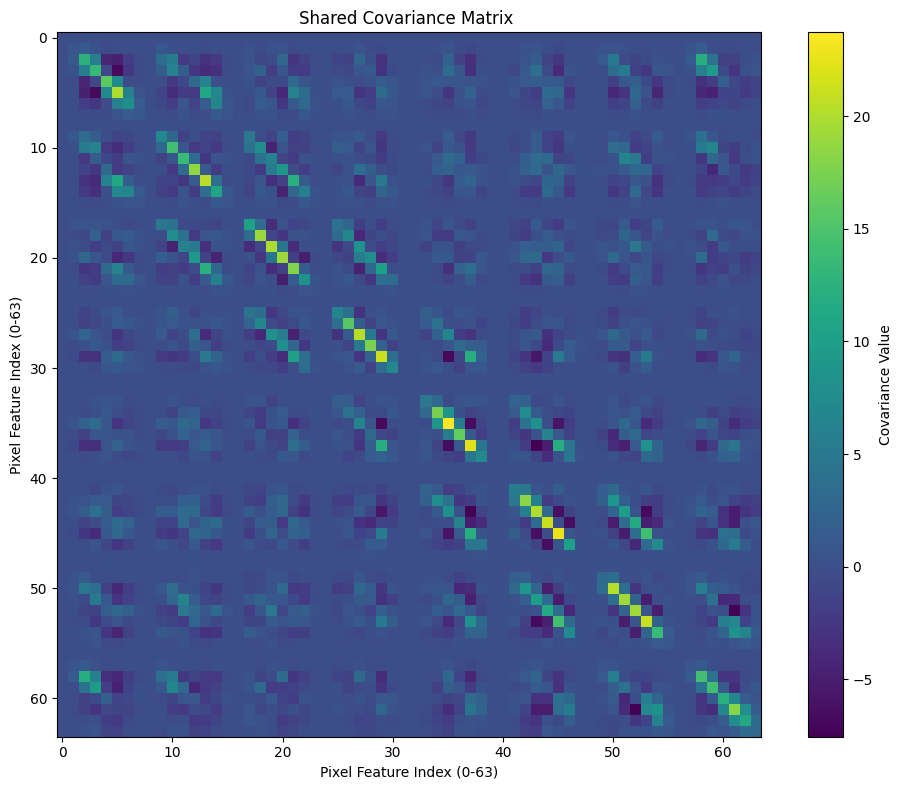

In [55]:

X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

final_model = GaussianGenerativeClassifier(lambda_reg=best_lambda)
final_model.fit(X_combined, y_combined)

y_pred_test = final_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
print(f"Final Test Accuracy: {test_acc:.4f}")
print("\nClassification Report (Macro Avg):")
print(classification_report(y_test, y_pred_test, digits=3))
final_model.plot_shared_covariance()


### confusion matrix

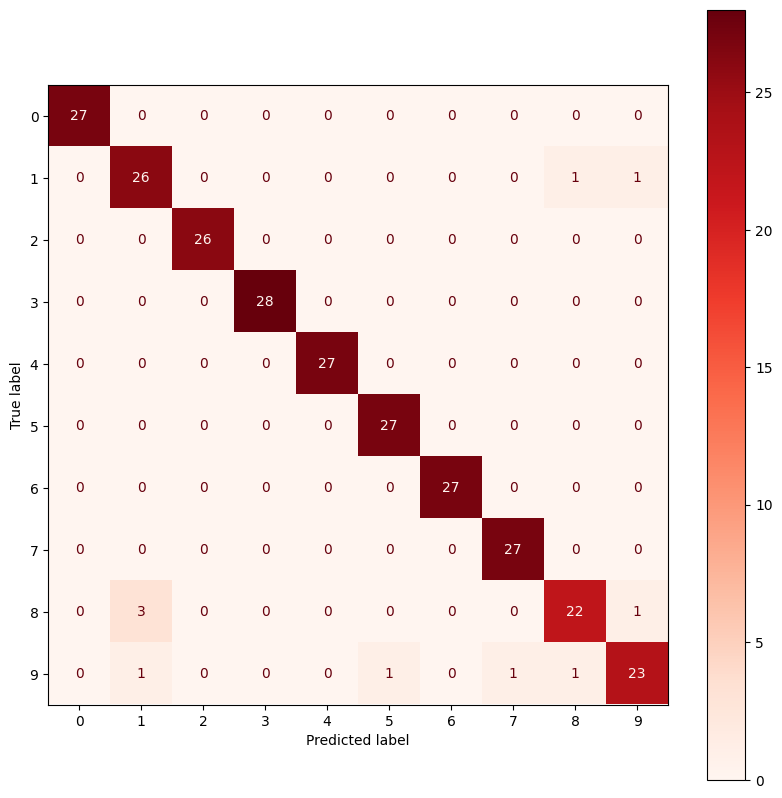

In [36]:

conf_mat = confusion_matrix(y_test, y_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=final_model.classes)
fig, ax = plt.subplots(figsize=(10, 10))
display.plot(ax=ax, cmap='Reds')
plt.show()

# The report



### 1. Explanation of the Gaussian Generative Model

**Generative Model:**
The model assumes that each class $k$ (digit 0-9) generates prob distribution  according to a multivariate Gaussian distribution.

**Parameter Estimation:**
1. **Class Priors** ($\pi_k$): Estimated as the div of samples in each class in the training set over the whole training set.
2. **Class Means** ($\mu_k$): Estimated as the  mean of all samples belonging to class $k$.
3. **Shared Covariance** ($\Sigma$): Estimated by summing  $(x_i - \mu_{y_i})(x_i - \mu_{y_i})^T$ over all training samples and dividing by the total number of samples.

**Regularization:**

- Without regularization, $\Sigma$ may be poorly conditioned, leading to numerical instability when inverting or computing determinants.
- A small $\lambda$ provides stability but may not fully address overfitting.
- A large $\lambda$ over-smooths the covariance, reducing model capacity (underfitting).



### 2. Validation Accuracy for each lambda value

| lambda | Validation Accuracy |
| :------- | :------------------ |
| 0.0001   | 0.9444              |
| 0.001    | 0.9444              |
| 0.01     | 0.9444              |
| 0.1      | 0.9407              |


### 3. Summary of Final Test Results

After tuning lambda  on the validation set, the best lambda wasn't so clear it was between .0001 and .001 and .01 so we chose the least possible value which was `0.0001`. After combining training and validation sets with this best lambda and evaluated on the test set.

*   **Final Test Accuracy:** 0.9630

*   **Classification Report (Macro Avg):**
    ```
                  precision    recall  f1-score   support

               0      1.000     1.000     1.000        27
               1      0.867     0.929     0.897        28
               2      1.000     1.000     1.000        26
               3      1.000     1.000     1.000        28
               4      1.000     1.000     1.000        27
               5      0.964     1.000     0.982        27
               6      1.000     1.000     1.000        27
               7      0.964     1.000     0.982        27
               8      0.917     0.846     0.880        26
               9      0.920     0.852     0.885        27

        accuracy                          0.963       270
       macro avg      0.963     0.963     0.962       270
    weighted avg      0.963     0.963     0.963       270
    ```

*   **Confusion Matrix:**

    ```
    array([[27,  0,  0,  0,  0,  0,  0,  0,  0,  0],
           [ 0, 26,  0,  0,  0,  0,  0,  0,  1,  1],
           [ 0,  0, 26,  0,  0,  0,  0,  0,  0,  0],
           [ 0,  0,  0, 28,  0,  0,  0,  0,  0,  0],
           [ 0,  0,  0,  0, 27,  0,  0,  0,  0,  0],
           [ 0,  0,  0,  0,  0, 27,  0,  0,  0,  0],
           [ 0,  0,  0,  0,  0,  0, 27,  0,  0,  0],
           [ 0,  0,  0,  0,  0,  0,  0, 27,  0,  0],
           [ 0,  3,  0,  0,  0,  0,  0,  0, 22,  1],
           [ 0,  1,  0,  0,  0,  1,  0,  1,  1, 23]])
    ```

### 4. Discussion

**Which digits are most often confused with each other?**

the digits most frequently confused are 1, 8, and 9. Specifically, digit '8' was misclassified as '1' three times.

**How much the choice of lambda affected performance?**

The choice of lambda  within the tested range (0.0001 to 0.1) had a relatively minor impact on the validation accuracy.

**Observations about the strengths and weaknesses of this Gaussian generative model on the digits dataset:**

**Strengths:** Simple and Fast and has high accuracy

**Weaknesses:** Usage of the shared covariance matrix made it assume that all the numbers have the same ellipse(spread and direction of it) but that is not true